In [1]:
"""
Wczytanie bibliotek potrzebnych do realizacji projektu
"""
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import statistics
import pandas as pd

In [2]:
"""
Utworzenie klasy GLCM z konstruktorem, który konwertuje obrazy do skali szarości oraz metodami oblcizającymi GLCM
"""
class GLCM:

    def __init__(self, srcImage):
        self.BaseImage = np.uint8(srcImage)
        self.rgbImage = cv.cvtColor(self.BaseImage, cv.COLOR_BGR2RGB)
        self.xyzImage = cv.cvtColor(self.BaseImage, cv.COLOR_BGR2XYZ)
        self.labImage = cv.cvtColor(self.BaseImage, cv.COLOR_BGR2LAB)
        self.hlsImage = cv.cvtColor(self.BaseImage, cv.COLOR_BGR2HLS)
        self.hsvImage = cv.cvtColor(self.BaseImage, cv.COLOR_BGR2HSV)

        self.rgbGray = cv.cvtColor(self.rgbImage, cv.COLOR_RGB2GRAY)
        self.xyzGray = self.BaseImage[:, :, 1]
        self.labGray = self.BaseImage[:, :, 0]
        self.hlsGray = self.BaseImage[:, :, 1]
        self.hsvGray = self.BaseImage[:, :, 2]

        self.colorsGrays = [self.rgbGray, self.xyzGray, self.labGray, self.hlsGray, self.hsvGray]

    """Metoda obliczająca GLCM horyzontalny [w prawo, w lewo oraz symetrycznie]"""
    def GLCM_horizontal(self, src):
        Operator = src.copy()
        GLCM_HorRight = np.zeros((256, 256))
        h, w = Operator.shape

        for i in range(h):
            for j in range(w - 1):
                get_px = np.array([Operator[i, j], Operator[i, j + 1]])
                GLCM_HorRight[get_px[0], get_px[1]] += 1

        GLCM_HorLeft = np.matrix.transpose(GLCM_HorRight)
        GLCM_HorSym = GLCM_HorRight + GLCM_HorLeft
        return GLCM_HorRight, GLCM_HorLeft, GLCM_HorSym

    """Metoda obliczająca GLCM pionowy [w dół, w górę oraz symetrycznie]"""
    def GLCM_vertical(self, src):
        Operator = src.copy()
        GLCM_VertDown = np.zeros((256, 256))
        h, w = Operator.shape

        for i in range(h-1):
            for j in range(w):
                get_px = np.array([Operator[i, j], Operator[i + 1, j]])
                GLCM_VertDown[get_px[0], get_px[1]] += 1

        GLCM_VertUp = np.matrix.transpose(GLCM_VertDown)
        GLCM_VertSym = GLCM_VertDown + GLCM_VertDown
        return GLCM_VertDown, GLCM_VertUp, GLCM_VertSym

    """Metoda obliczająca GLCM ukośny [lewa góra - prawy dół, prawy dół - lewa góra oraz symetrycznie]"""
    def GLCM_diagonal_LeftToRight_Reverse(self, src):
        Operator = src.copy()
        GLCM_PrimTop_SecDown = np.zeros((256, 256))
        h, w = Operator.shape

        for i in range(h-1):
            for j in range(w-1):
                get_px = np.array([Operator[i,j], Operator[i+1, j+1]])
                GLCM_PrimTop_SecDown[get_px[0], get_px[1]] += 1

        GLCM_PrimDown_SecTop = np.matrix.transpose(GLCM_PrimTop_SecDown)
        GLCM_LeftToRight_Symetric = GLCM_PrimTop_SecDown + GLCM_PrimDown_SecTop
        return GLCM_PrimTop_SecDown, GLCM_PrimDown_SecTop, GLCM_LeftToRight_Symetric
    
    """Metoda obliczająca GLCM ukośny [prawa góra - lewy dół, lewy dół - prawa góra oraz symetrycznie]"""
    def GLCM_diagonal_RightToLeft_Reverse(self, src):
        Operator = src.copy()
        GLCM_PrimTop_SecDown = np.zeros((256, 256))
        h, w = Operator.shape

        for i in range(h-1):
            for j in range(1, w):
                get_px = np.array([Operator[i,j], Operator[i+1, j-1]])
                GLCM_PrimTop_SecDown[get_px[0], get_px[1]] += 1

        GLCM_PrimDown_SecTop = np.matrix.transpose(GLCM_PrimTop_SecDown)
        GLCM_RightToLeft_Symetric = GLCM_PrimTop_SecDown + GLCM_PrimDown_SecTop
        return GLCM_PrimTop_SecDown, GLCM_PrimDown_SecTop, GLCM_RightToLeft_Symetric


In [3]:
"""Funkcja normalizująca wejściową macierz GLCM"""
def NormalisedGLCM(GLCM):
    SumOfGLCM = np.sum(GLCM)
    Normalised = np.divide(GLCM, SumOfGLCM)
    return Normalised

"""Funkcja obliczająca energię dla wejściowej macierzy GLCM"""
def Energy(GLCM):
    PowerOfMatrix = np.power(GLCM, 2)
    SumOfMatrix = np.sum(PowerOfMatrix)
    return SumOfMatrix

"""Funkcja obliczająca kontrast dla wejściowej macierzy GLCM"""
def Contrast(GLCM):
    ContrastSum = 0
    for a in range(256):
        for b in range(256):
            ContrastSum += (np.power((a-b), 2) * GLCM[a, b])
    return ContrastSum

"""Funkcja obliczająca korelację dla wejściowej macierzy GLCM"""
def Correlation(GLCM):
    CorrelationSum = 0
    u = np.average(GLCM)
    o = np.std(GLCM)
    for a in range(256):
        for b in range(256):
            CorrelationSum += ((((a-u)*(b-u))/(np.power(o,2)))*GLCM[a, b])
    CorrelationResult = (-1) * CorrelationSum
    return CorrelationResult

"""Funkcja obliczająca wariancję dla wejściowej macierzy GLCM"""
def Variance(GLCM):
    VarianceSum = 0
    u = np.average(GLCM)
    for a in range(256):
        for b in range(256):
            VarianceSum += np.power((a-u), 2)*GLCM[a, b]
    return VarianceSum

"""Funkcja obliczająca jednorodność dla wejściowej macierzy GLCM"""
def Homogenity(GLCM):
    HomogenitySum = 0
    for a in range(256):
        for b in range(256):
            HomogenitySum += (GLCM[a, b] / (1 + np.power((a-b), 2)))
    return HomogenitySum

"""Funkcja obliczająca entropię dla wejściowej macierzy GLCM"""
def Entropy(GLCM):
    EntropySum = 0
    for a in range(256):
        for b in range(256):
            if (GLCM[a, b] != 0):
                EntropySum += (GLCM[a, b] * np.log10(GLCM[a, b]))
    EntropyResult = ((-1) * EntropySum)
    return EntropyResult

"""Funkcja obliczająca średnią wartość dla czterech wejściowych macierzy GLCM"""
def Prop_Mean(glProp_hor, glProp_ver, glProp_diag1, glProp_diag2):
    PropResult = (glProp_hor + glProp_ver + glProp_diag1 + glProp_diag2)/4
    return PropResult

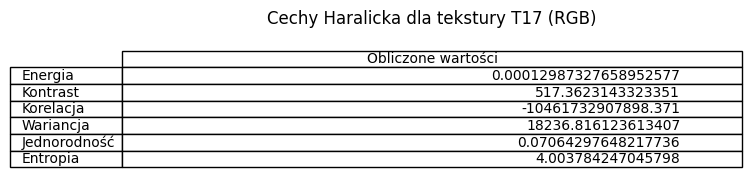

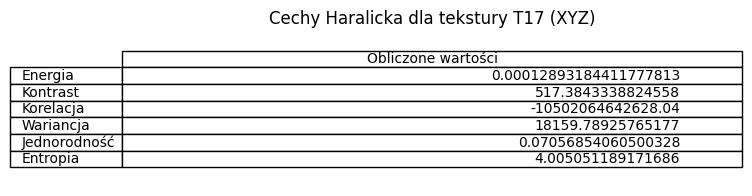

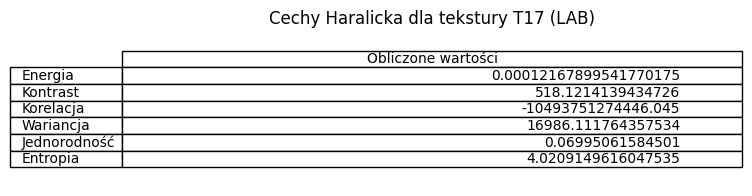

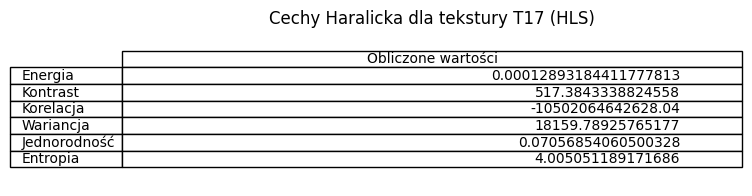

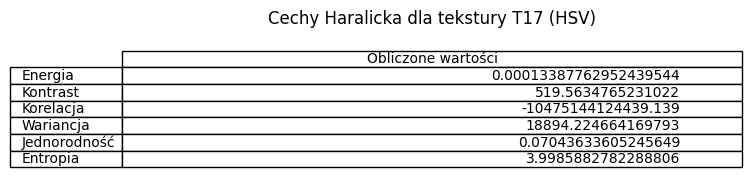

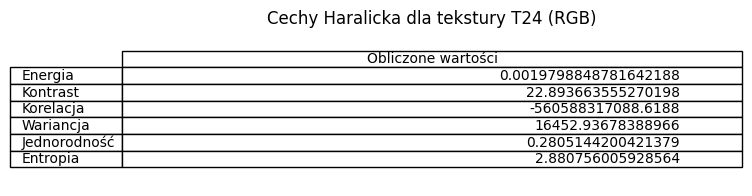

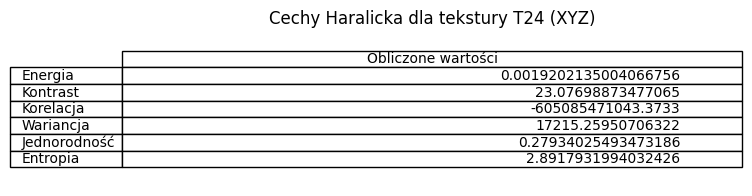

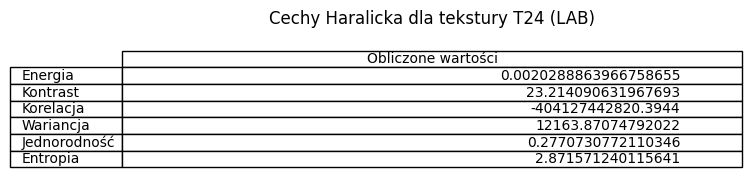

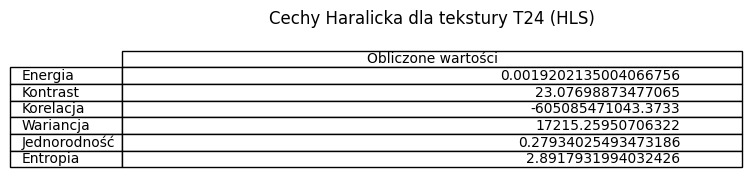

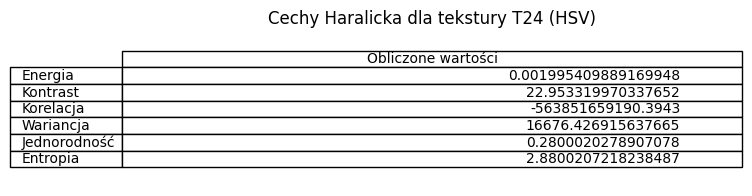

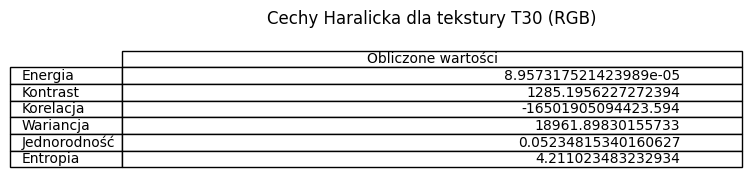

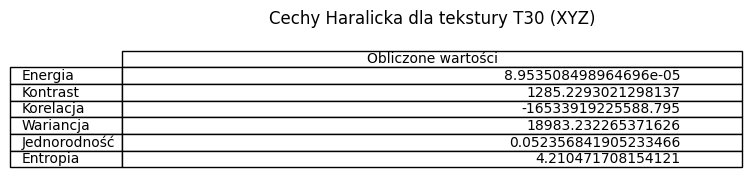

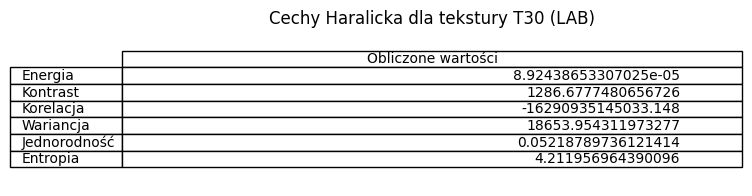

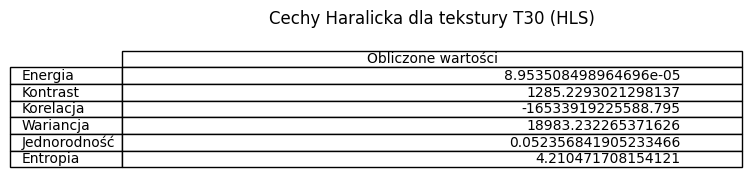

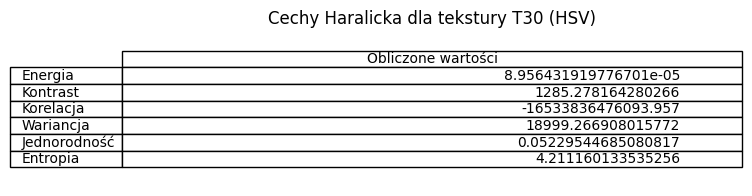

In [4]:
"""Wczytanie 3 różnych tekstur"""
Texture1 = GLCM(cv.imread("./Textures/T17.bmp"))
Texture2 = GLCM(cv.imread("./Textures/T24.bmp"))
Texture3 = GLCM(cv.imread("./Textures/T30.bmp"))

"""
Funkcja wyświetlająca tabele z wynikami dla wskazanych obrazów i palet ich kolorów
title - tytuł tabeli
inputTexture - textura wejściowa dla której oblcizane będą cechy
colorNumber - numer palety kolorów:
0 - RGB
1 - XYZ
2 - LAB
3 - HLS
4 - HSV
"""
def PrintResults(title, inputTexture, colorNumber):

    glHor = NormalisedGLCM(inputTexture.GLCM_horizontal(inputTexture.colorsGrays[colorNumber])[2])
    glVer = NormalisedGLCM(inputTexture.GLCM_vertical(inputTexture.colorsGrays[colorNumber])[2])
    glDiag1 = NormalisedGLCM(inputTexture.GLCM_diagonal_LeftToRight_Reverse(inputTexture.colorsGrays[colorNumber])[2])
    glDiag2 = NormalisedGLCM(inputTexture.GLCM_diagonal_RightToLeft_Reverse(inputTexture.colorsGrays[colorNumber])[2])
    
    TextureEnergy = Prop_Mean(Energy(glHor), Energy(glVer), Energy(glDiag1), Energy(glDiag2))
    TextureContrast = Prop_Mean(Contrast(glHor), Contrast(glVer), Contrast(glDiag1), Contrast(glDiag2))
    TextureCorrelation = Prop_Mean(Correlation(glHor), Correlation(glVer), Correlation(glDiag1), Correlation(glDiag2))
    TextureVariance = Prop_Mean(Variance(glHor), Variance(glVer), Variance(glDiag1), Variance(glDiag2))
    TextureHomogenity = Prop_Mean(Homogenity(glHor), Homogenity(glVer), Homogenity(glDiag1), Homogenity(glDiag2))
    TextureEntropy = Prop_Mean(Entropy(glHor), Entropy(glVer), Entropy(glDiag1), Entropy(glDiag2))

    Tex = pd.DataFrame({"Obliczone wartości": [TextureEnergy, TextureContrast, TextureCorrelation, TextureVariance, TextureHomogenity, TextureEntropy]})
    Tex.index = ["Energia", "Kontrast", "Korelacja", "Wariancja", "Jednorodność", "Entropia"]
    fig = plt.figure(figsize = (8, 2))
    ax = fig.add_subplot(111)
    ax.table(cellText = Tex.values, rowLabels = Tex.index, colLabels = Tex.columns, loc = "center")
    ax.set_title(title)
    ax.axis("off")

PrintResults("Cechy Haralicka dla tekstury T17 (RGB)",Texture1,0)
PrintResults("Cechy Haralicka dla tekstury T17 (XYZ)",Texture1,1)
PrintResults("Cechy Haralicka dla tekstury T17 (LAB)",Texture1,2)
PrintResults("Cechy Haralicka dla tekstury T17 (HLS)",Texture1,3)
PrintResults("Cechy Haralicka dla tekstury T17 (HSV)",Texture1,4)

PrintResults("Cechy Haralicka dla tekstury T24 (RGB)",Texture2,0)
PrintResults("Cechy Haralicka dla tekstury T24 (XYZ)",Texture2,1)
PrintResults("Cechy Haralicka dla tekstury T24 (LAB)",Texture2,2)
PrintResults("Cechy Haralicka dla tekstury T24 (HLS)",Texture2,3)
PrintResults("Cechy Haralicka dla tekstury T24 (HSV)",Texture2,4)

PrintResults("Cechy Haralicka dla tekstury T30 (RGB)",Texture3,0)
PrintResults("Cechy Haralicka dla tekstury T30 (XYZ)",Texture3,1)
PrintResults("Cechy Haralicka dla tekstury T30 (LAB)",Texture3,2)
PrintResults("Cechy Haralicka dla tekstury T30 (HLS)",Texture3,3)
PrintResults("Cechy Haralicka dla tekstury T30 (HSV)",Texture3,4)